In [1]:
# Generate an open / closed PFSS map from HMI polar-corrected synoptic maps

In [13]:
import gc
import logging
import os
import sys
import warnings

import astropy.constants as const
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pfsspy
from astropy.coordinates import SkyCoord
from pfsspy import tracing
from sunpy.coordinates.sun import carrington_rotation_time
from tqdm.notebook import tqdm

import matplotlib.dates as mdates

from astropy.visualization import time_support

warnings.filterwarnings('ignore')
logging.disable(sys.maxsize)

In [3]:
def keynote_figs():
    matplotlib.rcParams['lines.color'] = 'white'
    matplotlib.rcParams['patch.edgecolor'] = 'white'
    matplotlib.rcParams['text.color'] = 'white'
    matplotlib.rcParams['axes.facecolor'] = 'black'
    matplotlib.rcParams['axes.edgecolor'] = 'white'
    matplotlib.rcParams['axes.labelcolor'] = 'white'
    matplotlib.rcParams['xtick.color'] = 'white'
    matplotlib.rcParams['ytick.color'] = 'white'
    matplotlib.rcParams['grid.color'] = 'white'
    matplotlib.rcParams['figure.facecolor'] = 'black'
    matplotlib.rcParams['figure.edgecolor'] = 'black'
    matplotlib.rcParams['savefig.facecolor'] = 'black'
    matplotlib.rcParams['savefig.edgecolor'] = 'black'
    matplotlib.rcParams['font.size'] = 10
    matplotlib.rcParams['lines.linewidth'] = 1.5
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['text.usetex'] = False

def light_figs():
    matplotlib.rcParams['lines.color'] = 'black'
    matplotlib.rcParams['patch.edgecolor'] = 'black'
    matplotlib.rcParams['text.color'] = 'black'
    matplotlib.rcParams['axes.facecolor'] = 'white'
    matplotlib.rcParams['axes.edgecolor'] = 'black'
    matplotlib.rcParams['axes.labelcolor'] = 'black'
    matplotlib.rcParams['xtick.color'] = 'black'
    matplotlib.rcParams['ytick.color'] = 'black'
    matplotlib.rcParams['grid.color'] = 'black'
    matplotlib.rcParams['figure.facecolor'] = 'white'
    matplotlib.rcParams['figure.edgecolor'] = 'white'
    matplotlib.rcParams['savefig.facecolor'] = 'white'
    matplotlib.rcParams['savefig.edgecolor'] = 'white'
    matplotlib.rcParams['font.size'] = 10
    matplotlib.rcParams['lines.linewidth'] = 1.5
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['text.usetex'] = False

def latex_figs():
    matplotlib.rcParams['lines.color'] = 'black'
    matplotlib.rcParams['patch.edgecolor'] = 'black'
    matplotlib.rcParams['text.color'] = 'black'
    matplotlib.rcParams['axes.facecolor'] = 'white'
    matplotlib.rcParams['axes.edgecolor'] = 'black'
    matplotlib.rcParams['axes.labelcolor'] = 'black'
    matplotlib.rcParams['xtick.color'] = 'black'
    matplotlib.rcParams['ytick.color'] = 'black'
    matplotlib.rcParams['grid.color'] = 'black'
    matplotlib.rcParams['figure.facecolor'] = 'white'
    matplotlib.rcParams['figure.edgecolor'] = 'white'
    matplotlib.rcParams['savefig.facecolor'] = 'white'
    matplotlib.rcParams['savefig.edgecolor'] = 'white'
    matplotlib.rcParams['font.size'] = 10
    matplotlib.rcParams['lines.linewidth'] = 1.0
    matplotlib.rcParams['font.family'] = 'serif'
    matplotlib.rcParams['text.usetex'] = True


light_figs()
# latex_figs()
#keynote_figs()

In [4]:
datadir = '/Users/clowder/data/'

In [5]:
# Set a range of data
crs = np.arange(2097,2297)

In [24]:
dates = carrington_rotation_time(crs)
dates[0].value

'2010-05-19 23:55:17.939'

In [ ]:
dates = carrington_rotation_time(crs)
tmin, tmax = mdates.date2num([dates[0].value, dates[-1].value])
tmin, tmax

(np.float64(14748.996735405091), np.float64(20176.811440497688))

In [7]:
len(crs)

200

In [ ]:
nsteps = 360
ofmap = np.zeros((nsteps, len(crs)))
efmap = np.zeros((nsteps, len(crs)))

with tqdm(total=len(crs)) as pbar:
    for i, cr in enumerate(crs):
        output_file = datadir + 'pfss/crs/' + 'pfss_ofmap_cr' + str(cr) + '.npz'
        
        if os.path.exists(output_file):
            data = np.load(output_file)
            pols, expfs = data['ofmap'], data['efmap']
        else:
            hmi_map = sunpy.map.Map(datadir + 'hmi.Synoptic_Mr.polfil/hmi.synoptic_mr_polfil_720s.' + str(cr) + '.Mr_polfil.fits')
            hmi_map = hmi_map.resample([2 * nsteps, nsteps] * u.pix)

            nrho = 40
            rss = 2.5
            pfss_in = pfsspy.Input(hmi_map, nrho, rss)
            pfss_out = pfsspy.pfss(pfss_in)

            r = const.R_sun
            lon_1d = np.linspace(0, 2 * np.pi, nsteps * 2)
            lat_1d = np.arcsin(np.linspace(-0.999, 0.999, nsteps))
            lon, lat = np.meshgrid(lon_1d, lat_1d, indexing='ij')
            lon, lat = lon * u.rad, lat * u.rad
            seeds = SkyCoord(lon.ravel(), lat.ravel(), r, frame=pfss_out.coordinate_frame)

            tracer = tracing.FortranTracer(max_steps=2000)
            field_lines = tracer.trace(seeds, pfss_out)

            pols = field_lines.polarities.reshape(2 * nsteps, nsteps).T
            expfs = field_lines.expansion_factors.reshape(2 * nsteps, nsteps).T
            expfs[np.where(np.isnan(expfs))] = 0

            np.savez_compressed(output_file, ofmap=pols, efmap=expfs, brmap=hmi_map.data, lon=lon_1d, lat=lat_1d)
            
            del hmi_map, pfss_in, pfss_out, lon, lat, seeds, field_lines
            gc.collect()
        
        ofmap[:, i] = pols.sum(axis=1) / pols.shape[1]
        efmap[:, i] = expfs.sum(axis=1) / expfs.shape[1]

        pbar.update(1)

  0%|          | 0/200 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1087b2120>>
Traceback (most recent call last):
  File "/Users/clowder/work/pfss/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [8]:
nsteps = 360
ofmap = np.zeros((nsteps,len(crs)))
efmap = np.zeros((nsteps,len(crs)))
brmap = np.zeros((nsteps,len(crs)))

for i, cr in enumerate(crs):
    data = np.load(datadir + 'pfss/crs/' + 'pfss_ofmap_cr' + str(cr) + '.npz')
    ofmap[:,i] = data['ofmap'].sum(axis=1) / data['ofmap'].shape[1]
    efmap[:,i] = data['efmap'].sum(axis=1) / data['efmap'].shape[1]
    brmap[:,i] = data['brmap'].sum(axis=1) / data['brmap'].shape[1]


In [9]:
dates[0]

<Time object: scale='utc' format='iso' value=2010-05-19 23:55:17.939>

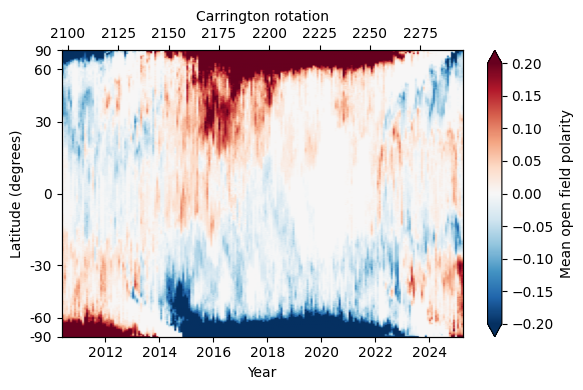

In [41]:
f, (ax1) = plt.subplots(1, figsize=(6,4))
im = ax1.imshow(ofmap, extent=[tmin, tmax, -1, 1], cmap='RdBu_r', vmin=-0.2, vmax=0.2, aspect='auto')
plt.colorbar(im, ax=ax1, extend='both', label='Mean open field polarity')

ax1b = ax1.twiny()
latticks = np.array([-90,-60,-30,0,30,60,90])
ax1.set_yticks(np.sin(latticks*np.pi/180))
ax1.set_yticklabels(latticks)
ax1b.set_xlim(crs[0], crs[-1])
ax1.xaxis_date()

ax1.set_xlabel('Year')
ax1b.set_xlabel('Carrington rotation')
ax1.set_ylabel('Latitude (degrees)')
# ax1.set_title('PFSS Open Field Map')

plt.tight_layout()
plt.savefig('pfss_ofmap.pdf')

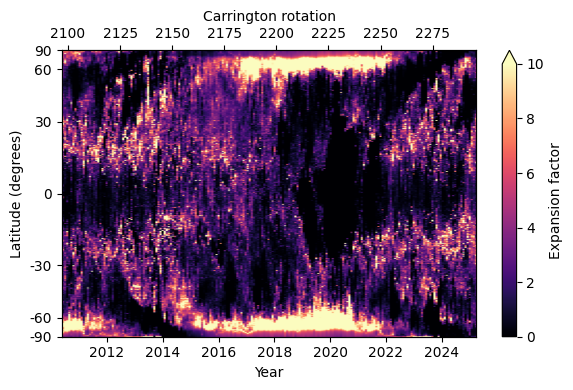

In [42]:
f, (ax1) = plt.subplots(1, figsize=(6,4))
im = ax1.imshow(efmap, vmin=0, vmax=10, extent=[tmin, tmax, -1, 1], cmap='magma', aspect='auto')
plt.colorbar(im, ax=ax1, extend='max', label='Expansion factor')

ax1b = ax1.twiny()
latticks = np.array([-90,-60,-30,0,30,60,90])
ax1.set_yticks(np.sin(latticks*np.pi/180))
ax1.set_yticklabels(latticks)
ax1b.set_xlim(crs[0], crs[-1])
ax1.xaxis_date()

ax1.set_xlabel('Year')
ax1b.set_xlabel('Carrington rotation')
ax1.set_ylabel('Latitude (degrees)')
# ax1.set_title('PFSS Open Field Map')

plt.tight_layout()
plt.savefig('pfss_efmap.pdf')

Text(0.5, 1.0, 'Br')

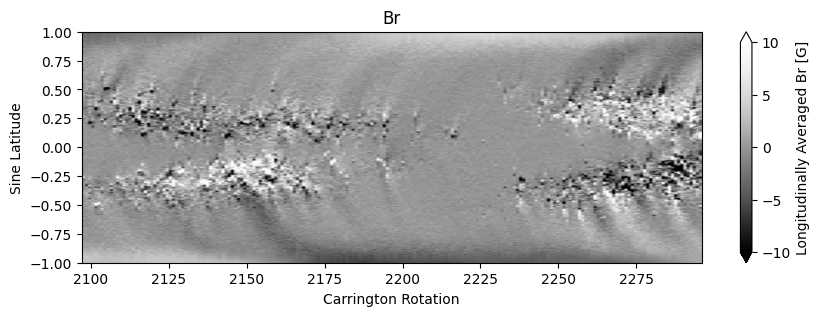

In [12]:
f, (ax1) = plt.subplots(1, figsize=(10,3))
im = ax1.imshow(brmap, vmin=-10, vmax=10, extent=[crs[0], crs[-1], -1, 1], cmap='Greys_r', aspect='auto')
plt.colorbar(im, ax=ax1, extend='both', label='Longitudinally Averaged Br [G]')
ax1.set_xlabel('Carrington Rotation')
ax1.set_ylabel('Sine Latitude')
ax1.set_title('Br')